## Reproductible forecasting

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import jmstate
from jmstate import MultiStateJointModel
from uniformbands import get_bands

In [17]:
torch.manual_seed(0)
sigmoid = torch.jit.script(jmstate.functions.sigmoid)

@torch.jit.script
def f(gamma, x, b):
    psi = gamma + b
    psi[:, 1].exp_()
    return psi

In [18]:
lmda, k = 6, 2
gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.diag(torch.tensor([1.0, 0.1, 1.0]))
R = torch.tensor([[1.1]])
Q_chol = torch.linalg.cholesky(Q)
R_chol = torch.linalg.cholesky(R)

alphas = {(0, 1): torch.tensor([.7])}
betas = {(0, 1): torch.tensor([-.5, .5, 1.2])}

real_params = jmstate.types.ModelParams(
    gamma,
    (jmstate.utils.flat_from_cov(Q, method="diag"), "diag"),
    (jmstate.utils.flat_from_cov(R, method="ball"), "ball"),
    alphas,
    betas
)

In [19]:
weibull_fn = jmstate.functions.weibull(k, lmda)
surv = {(0, 1): (weibull_fn, sigmoid)}
model_design = jmstate.types.ModelDesign(f, sigmoid, surv)
real_model = MultiStateJointModel(model_design, real_params, n_quad=128)

n, p = 500, 3
t = torch.linspace(0, 15, 15)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, p)
b = torch.randn(n, gamma.shape[0]) @ Q_chol
psi = f(gamma, x, b)

trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = jmstate.types.SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c)


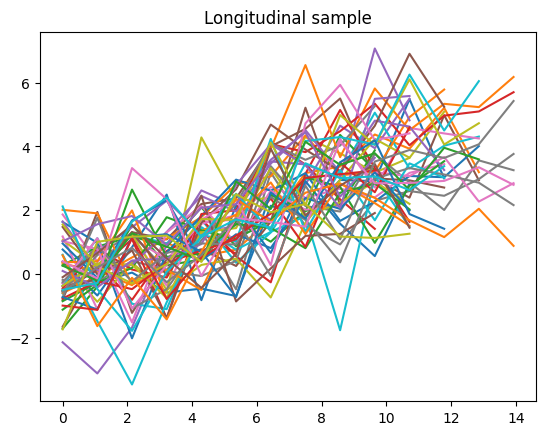

In [20]:
y = model_design.regression_fn(t, psi)
y += torch.randn_like(y) * torch.sqrt(R)
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan

plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.show()

In [21]:
init_params = jmstate.types.ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(jmstate.utils.flat_from_cov(Q, method="diag")), "diag"),
    (torch.zeros_like(jmstate.utils.flat_from_cov(R, method="ball")), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = jmstate.types.ModelData(x, t, y, trajectories, c)
model = MultiStateJointModel(model_design, init_params)
model.fit(data, n_iter=3000)
model.get_metrics(callbacks=[jmstate.callbacks.compute_criteria, jmstate.callbacks.compute_fim])
print("Fitted parameters:", model.params_)
print("Fitted metrics:", model.metrics_)

Fitting joint model:  46%|████▋     | 1388/3000 [00:08<00:09, 167.52it/s]


KeyboardInterrupt: 

In [ ]:
n_test = 100
x_test = torch.randn(n_test, p)
b_test = torch.randn(n_test, gamma.shape[0]) @ Q_chol
psi_test = f(gamma, x_test, b_test)
trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]

y_test = model_design.regression_fn(t, psi_test)
y_test += torch.randn_like(y_test) @ R_chol

Predicting survival log probabilities: 100%|██████████| 500/500 [00:24<00:00, 20.55it/s]


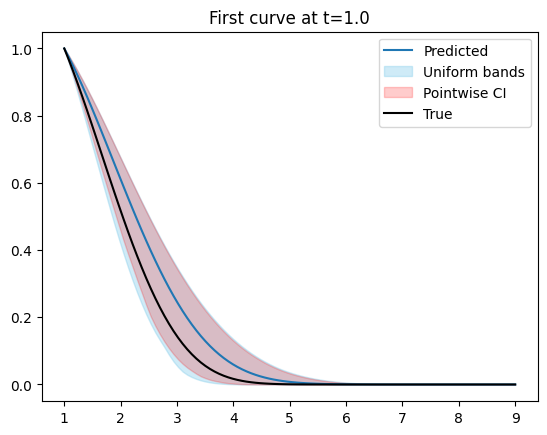

Time 1.0: Uniform coverage = 0.910, Pointwise coverage = 0.820


Predicting survival log probabilities:  44%|████▍     | 221/500 [00:10<00:13, 20.19it/s]


KeyboardInterrupt: 

In [ ]:
prediction_times = torch.linspace(1.0, 6.0, 4)
u_grid = torch.linspace(0, 8, 64)

log_probs_true = []
for time in prediction_times:
    c_test = torch.full((n_test,), time)
    sample_test_data = jmstate.types.SampleData(x_test, trajectories_init_test, psi_test, c_test)
    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    log_probs_true.append(real_model.compute_surv_log_probs(sample_test_data, u))

uniform_coverage = []
pointwise_coverage = []

for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time)

    pred_test_data = jmstate.types.ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )

    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    log_probs_pred = real_model.predict_surv_log_probs(pred_test_data, u, n_iter_b=1000, cont_warmup=10)

    uniform_covered_count = 0
    pointwise_covered_count = 0

    for j in range(n_test):
        true_prob_j = torch.exp(log_probs_true[i][j]).numpy()
        pred_probs_j = torch.vstack([torch.exp(lp[j].detach()) for lp in log_probs_pred]).numpy()

        bands_j = get_bands(pred_probs_j)
        pointwise_j = np.quantile(pred_probs_j, [0.025, 0.975], axis=0)

        uniform_covered_count += np.all((true_prob_j >= bands_j["lower"]) & (true_prob_j <= bands_j["upper"]))
        pointwise_covered_count += np.all((true_prob_j >= pointwise_j[0]) & (true_prob_j <= pointwise_j[1]))

        # Plot first curve only
        if j == 0:
            points = time + u_grid
            plt.plot(points, pred_probs_j.mean(axis=0), label="Predicted")
            plt.fill_between(points, bands_j["lower"], bands_j["upper"], color="skyblue", alpha=0.4, label="Uniform bands")
            plt.fill_between(points, pointwise_j[0], pointwise_j[1], color="red", alpha=0.2, label="Pointwise CI")
            plt.plot(points, true_prob_j, label="True", color="black")
            plt.title(f"First curve at t={time:.1f}")
            plt.legend()
            plt.show()

    uniform_coverage.append(uniform_covered_count / n_test)
    pointwise_coverage.append(pointwise_covered_count / n_test)

    print(f"Time {time:.1f}: Uniform coverage = {uniform_coverage[-1]:.3f}, Pointwise coverage = {pointwise_coverage[-1]:.3f}")

print("\nOverall coverage:")
print(f"Uniform bands: {np.mean(uniform_coverage):.3f}")
print(f"Pointwise CI: {np.mean(pointwise_coverage):.3f}")